# Assignment 2 Group 15 Data Visualization<br>
## Index
1. Import Requirements
2. 

In [192]:
## Import requirements
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

In [193]:
## Collect data from ElasticSearch
from elasticsearch import helpers

ELASTIC_SEARCH_SERVER= "https://localhost:9200"
es = Elasticsearch(ELASTIC_SEARCH_SERVER, basic_auth=("elastic", "elastic"), verify_certs=False)

# Test the elastic cluster health
try:
    health = es.cluster.health()
    print("Cluster health:", health)
except Exception as e:
    print(f"Error connecting to Elasticsearch: {e}")

# Indexs of data
weather_index = "weather-data1"
traffic_index_2023 = "traffic-2023"
income_index = "all_states_income-data"

index_list = [weather_index, traffic_index_2023, income_index] 

# Create empty lists for weather, income, and traffic data
weather_data = []
income_data = []
traffic_2023_data = []

for ind in index_list:
    # Initialize the scroll
    response = es.search(
        index=ind,
        body={
            'query': {
                'match_all': {}
            }
        },
        scroll='2m',  # Scroll context time
        size=10000    # Number of documents per batch
    )
    
    # Get the scroll ID
    scroll_id = response['_scroll_id']
    scroll_size = len(response['hits']['hits'])
    
    # Keep fetching data until the scroll is done
    while scroll_size > 0:
        # Append the current batch of hits to the corresponding list
        if ind == weather_index:
            weather_data.extend([hit['_source'] for hit in response['hits']['hits']])
        elif ind == income_index:
            income_data.extend([hit['_source'] for hit in response['hits']['hits']])
        elif ind == traffic_index_2023:
            traffic_2023_data.extend([hit['_source'] for hit in response['hits']['hits']])
        
        # Fetch the next batch of data
        response = es.scroll(
            scroll_id=scroll_id,
            scroll='2m'
        )
        
        # Update the scroll ID
        scroll_id = response['_scroll_id']
        # Get the number of results that were returned in the last scroll
        scroll_size = len(response['hits']['hits'])

# Convert the lists to dataframes
weather_df = pd.DataFrame(weather_data)
income_df = pd.DataFrame(income_data)
traffic_2023_df = pd.DataFrame(traffic_2023_data)  

# print(weather_df)
# print(income_df)
# print(traffic_2023_df)

    
# print(weather_data)

/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Cluster health: {'cluster_name': 'elasticsearch', 'status': 'green', 'timed_out': False, 'number_of_nodes': 2, 'number_of_data_nodes': 2, 'active_primary_shards': 38, 'active_shards': 76, 'relocating_shards': 0, 'initializing_shards': 0, 'unassigned_shards': 0, 'delayed_unassigned_shards': 0, 'number_of_pending_tasks': 0, 'number_of_in_flight_fetch': 0, 'task_max_waiting_in_queue_millis': 0, 'active_shards_percent_as_number': 100.0}


/var/folders/v8/5m92pwd52hj2jgl3z_g3wjlc0000gn/T/ipykernel_56892/1173974477.py:28: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(
/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/jugyeongkim/miniconda3/envs/CloudComputingA2/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  war

In [141]:
# print(weather_df)
# print(income_df)
# print(traffic_2023_df)

In [194]:
# for data in weather_data:
#     print(data)
print(weather_data[0])


{'station_name': 'Green Cape', 'history_product': 'IDN60801', 'latitude': -37.3, 'longitude': 150.1, 'temperature': 16.1, 'apparent_temperature': 10.1, 'humidity': 61, 'wind_speed_kmh': 30, 'wind_speed_kt': 16, 'gust_speed_kmh': 35, 'gust_speed_kt': 19, 'pressure': 1027.8, 'rainfall': '0.0', 'weather': '-', 'cloud_cover': '-', 'visibility': '-', 'timestamp': '20240521113000'}


In [195]:
weather_df = weather_df.rename(columns={'station_name': 'suburb'})
income_df  = income_df.rename(columns={'lga_name':'suburb'})

def change_id_to_state(id):
    state = ""
    try:
        if id == "IDN60801":
            state = "NSW"
        elif id == "IDV60801":
            state = "Vic"
        elif id == "IDQ60801":
            state = "Qld"
        elif id == "IDS60801":
            state = "SA"
        elif id == "IDW60801":
            state = "WA"
        elif id == "IDD60801":
            state = "NT" 
    except:
        state = "Other"
    return state
    
income_df['State'] = income_df['lga_code'].apply(lambda x: 'NSW' if str(x).startswith('1') 
                                                 else ('Vic' if str(x).startswith('2') 
                                                 else ('Qld' if str(x).startswith('3') 
                                                 else ('SA' if str(x).startswith('4') 
                                                 else ('WA' if str(x).startswith('5') 
                                                 else ('Tas' if str(x).startswith('6') 
                                                 else ('NT' if str(x).startswith('7') 
                                                #  else ('ACT' if str(x).startswith('8') 
                                                 else 'Other')))))))

# Create a 'State' column based on the 'history_product'
weather_df['State'] = weather_df['history_product'].apply(change_id_to_state)

def extract_month(timestamp):
    # The month is represented by the 5th and 6th characters in the timestamp string
    month = int(timestamp[4:6])
    return str(month)

# Create a 'Month' column based on the 'timestamp'
weather_df['Month'] = weather_df['timestamp'].apply(extract_month)


# Merge weather and income by station
merged_df_station = pd.merge(weather_df, income_df, on='suburb', how='inner')
# print(merged_df_station)
unique_values = merged_df_station['suburb'].unique()
print(unique_values)

['Wellington' 'Forbes' 'Griffith' 'Walgett' 'Bourke' 'Ballina' 'Mildura'
 'Coonamble' 'Hunters Hill' 'Ballarat' 'Warrnambool' 'Laverton' 'Horsham'
 'Cobar' 'Richmond' 'Brewarrina' 'Kiama' 'Penrith' 'Camden' 'Goondiwindi'
 'Narrabri' 'Temora' 'Campbelltown' 'Cowra' 'Albury' 'Wangaratta'
 'Lithgow' 'Benalla' 'Swan Hill' 'Wagga Wagga' 'Mount Gambier'
 'Port Augusta' 'Hobart' 'Mandurah' 'Lake Grace' 'Wandering'
 'Lockhart River' 'Townsville' 'Rockhampton' 'Winton' 'Gladstone'
 'Toowoomba' 'Halls Creek' 'Carnarvon' 'Port Hedland' 'Broome' 'Mount Isa'
 'Longreach' 'Cairns' 'Gympie' 'Brisbane' 'Mareeba' 'Manjimup' 'Perth'
 'Karratha' 'Cloncurry' 'Kowanyama' 'Weipa' 'Mackay' 'Roxby Downs'
 'Bunbury' 'Esperance' 'Whyalla' 'Inverell' 'Dalwallinu' 'Elliston'
 'Mount Barker' 'Mitchell' 'Beverley' 'Launceston' 'Ceduna' 'Meekatharra'
 'Northam' 'Corrigin' 'Albany' 'Cleve' 'Kimba' 'Wagin' 'York' 'Brookton'
 'Narrogin' 'Bundaberg' 'Streaky Bay' 'Barcaldine' 'Ararat'
 'Murray Bridge' 'Strathbogie' 'Par

/var/folders/v8/5m92pwd52hj2jgl3z_g3wjlc0000gn/T/ipykernel_56892/3716035696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suburb_data['rainfall'] = pd.to_numeric(suburb_data['rainfall'], errors='coerce')
/var/folders/v8/5m92pwd52hj2jgl3z_g3wjlc0000gn/T/ipykernel_56892/3716035696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suburb_data['mean_aud'] = pd.to_numeric(suburb_data['mean_aud'], errors='coerce')


Hunters Hill average income : 136108.0 with average rainfall : 0.0
Laverton average income : 76187.0 with average rainfall : 0.597196261682243
Gladstone average income : 76985.0 with average rainfall : 0.0
Mount Isa average income : 77239.0 with average rainfall : 0.0
Karratha average income : 77036.0 with average rainfall : 0.0
Weipa average income : 88228.0 with average rainfall : 0.0
Esperance average income : 89475.0 with average rainfall : 0.05430463576158942
Northam average income : 137625.0 with average rainfall : 0.0
Wagin average income : 79583.0 with average rainfall : 0.0
Victor Harbor average income : 80068.0 with average rainfall : 1.4000000000000001
Pingelly average income : 84430.0 with average rainfall : 0.0
             suburb  mean_rainfall  mean_income
0        Wellington       0.000000      53614.0
1            Forbes       0.000000      51290.0
2          Griffith       0.007692      51511.0
3           Walgett       0.000000      32128.0
4            Bourke       

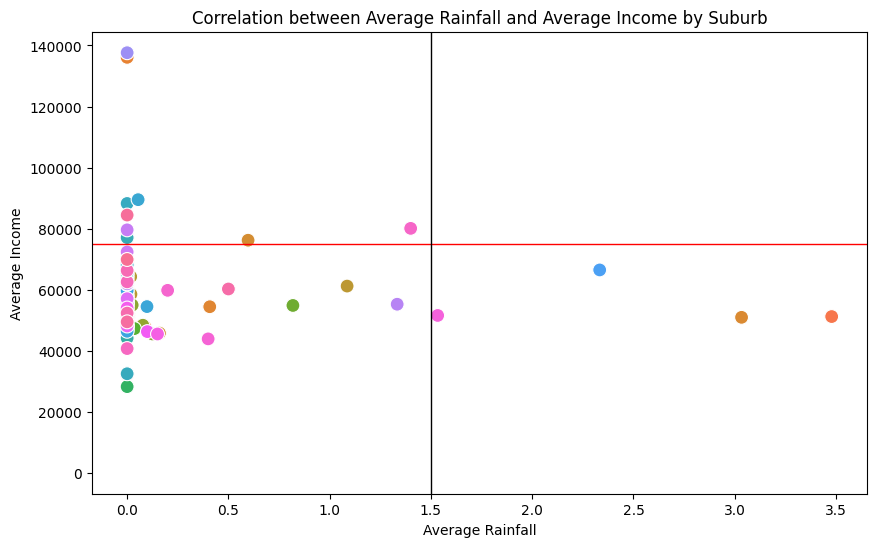

Correlation between Average Rainfall and Average Income: -0.01638814921367139


In [196]:
# Find Correlation between the average weather and average income of the suburb.

mean_data_list = []

for suburb in unique_values:
    # Filter rows for the current suburb
    suburb_data = merged_df_station[merged_df_station['suburb'] == suburb]

    suburb_data['rainfall'] = pd.to_numeric(suburb_data['rainfall'], errors='coerce')
    suburb_data['mean_aud'] = pd.to_numeric(suburb_data['mean_aud'], errors='coerce')
    # Calculate mean values for 'rainfall' and 'income'
    mean_rainfall = (suburb_data['rainfall']).mean()
    mean_income = suburb_data['mean_aud'].mean()
    if mean_rainfall <= 1.5 and mean_income >= 75000:
        print(f"{suburb} average income : {mean_income} with average rainfall : {mean_rainfall}")
    if mean_rainfall == mean_rainfall:
        mean_data_list.append({'suburb': suburb, 'mean_rainfall': mean_rainfall, 'mean_income': mean_income})


# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)
print(mean_data_df)

# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# mean_data_df = remove_outliers(mean_data_df, 'mean_rainfall')
# mean_data_df = remove_outliers(mean_data_df, 'mean_income')

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_rainfall', y='mean_income', hue='suburb', data=mean_data_df, s=100)
plt.title('Correlation between Average Rainfall and Average Income by Suburb')
plt.xlabel('Average Rainfall')
plt.ylabel('Average Income')
plt.axline((0,75000),(3,75000), linewidth=1, color="r")
plt.axline((1.5,0), (1.5,80000), linewidth=1, color="k")
plt.legend('',frameon=False)
#plt.legend(title='Suburb')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['mean_income'])

print(f"Correlation between Average Rainfall and Average Income: {correlation}")

In [200]:
# traffic_2023_df

# Merge weather and traffic_2023_df by State
merged_df_state = pd.merge(weather_df, traffic_2023_df, on='State')
unique_values = merged_df_state['State'].unique()
print(unique_values)
merged_df_suburb_income = pd.merge(weather_df, income_df, on='suburb')
unique_values_income = merged_df_suburb_income['suburb'].unique()
print(unique_values_income)

['NSW' 'Vic' 'SA' 'WA' 'Qld' 'NT']
['Wellington' 'Forbes' 'Griffith' 'Walgett' 'Bourke' 'Ballina' 'Mildura'
 'Coonamble' 'Hunters Hill' 'Ballarat' 'Warrnambool' 'Laverton' 'Horsham'
 'Cobar' 'Richmond' 'Brewarrina' 'Kiama' 'Penrith' 'Camden' 'Goondiwindi'
 'Narrabri' 'Temora' 'Campbelltown' 'Cowra' 'Albury' 'Wangaratta'
 'Lithgow' 'Benalla' 'Swan Hill' 'Wagga Wagga' 'Mount Gambier'
 'Port Augusta' 'Hobart' 'Mandurah' 'Lake Grace' 'Wandering'
 'Lockhart River' 'Townsville' 'Rockhampton' 'Winton' 'Gladstone'
 'Toowoomba' 'Halls Creek' 'Carnarvon' 'Port Hedland' 'Broome' 'Mount Isa'
 'Longreach' 'Cairns' 'Gympie' 'Brisbane' 'Mareeba' 'Manjimup' 'Perth'
 'Karratha' 'Cloncurry' 'Kowanyama' 'Weipa' 'Mackay' 'Roxby Downs'
 'Bunbury' 'Esperance' 'Whyalla' 'Inverell' 'Dalwallinu' 'Elliston'
 'Mount Barker' 'Mitchell' 'Beverley' 'Launceston' 'Ceduna' 'Meekatharra'
 'Northam' 'Corrigin' 'Albany' 'Cleve' 'Kimba' 'Wagin' 'York' 'Brookton'
 'Narrogin' 'Bundaberg' 'Streaky Bay' 'Barcaldine' 'Ararat'


/var/folders/v8/5m92pwd52hj2jgl3z_g3wjlc0000gn/T/ipykernel_56892/2155520881.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_data['rainfall'] = pd.to_numeric(state_data['rainfall'], errors='coerce')


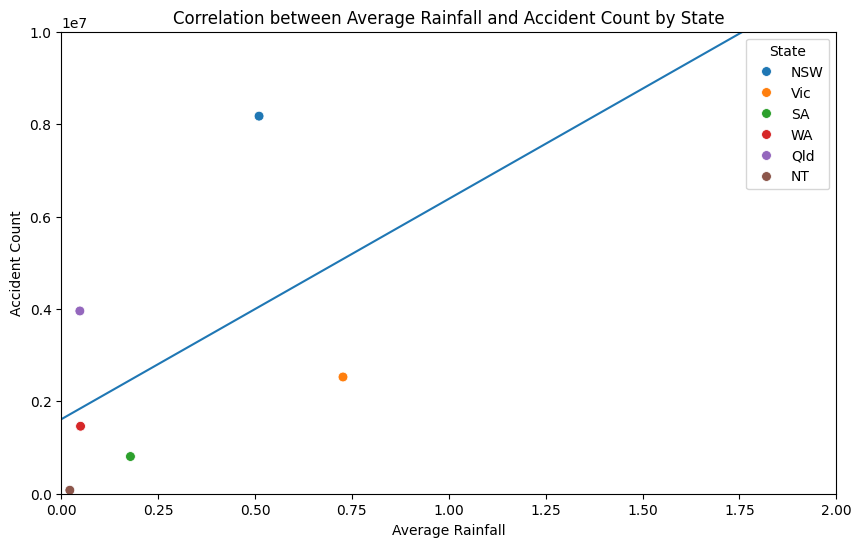

Correlation between Average Rainfall and Accident Count: 0.4761275116679146


In [202]:
# Find Correlation between the average weather and amount of traffic accidents of one State.

mean_data_list = []

for state in unique_values:
    # Filter rows for the current State
    state_data = merged_df_state[merged_df_state['State'] == state]

    state_data['rainfall'] = pd.to_numeric(state_data['rainfall'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and count of accidents
    mean_rainfall = state_data['rainfall'].mean()
    count_accident = (state_data['State'] == state).sum()
    
    mean_data_list.append({'State': state, 'mean_rainfall': mean_rainfall, 'count_accident': count_accident})

# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# Plotting
plt.figure(figsize=(10, 6))
m,b = np.polyfit(mean_data_df['mean_rainfall'], mean_data_df['count_accident'], 1)
plt.plot(x,m*x+b)
sns.scatterplot(x='mean_rainfall', y='count_accident', hue='State', data=mean_data_df, s=50)
plt.title('Correlation between Average Rainfall and Accident Count by State')
plt.xlabel('Average Rainfall')
plt.ylabel('Accident Count')
ax = plt.gca()
ax.set_xlim([0, 2])
ax.set_ylim([0, 10000000])
plt.legend(title='State')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['count_accident'])

print(f"Correlation between Average Rainfall and Accident Count: {correlation}")

Hunters Hill average income : 136108.0 with average wind speed : 4.389830508474576
Laverton average income : 76187.0 with average wind speed : 13.663551401869158
Gladstone average income : 76985.0 with average wind speed : 12.765100671140939
Mount Isa average income : 77239.0 with average wind speed : 20.08053691275168
Karratha average income : 77036.0 with average wind speed : 24.14189189189189
Weipa average income : 88228.0 with average wind speed : 17.553333333333335
Northam average income : 137625.0 with average wind speed : 1.3333333333333333
Wagin average income : 79583.0 with average wind speed : 11.5
Esperance average income : 89475.0 with average wind speed : 14.834437086092715
Victor Harbor average income : 80068.0 with average wind speed : 14.333333333333334
Pingelly average income : 84430.0 with average wind speed : 5.0


/var/folders/v8/5m92pwd52hj2jgl3z_g3wjlc0000gn/T/ipykernel_56892/3184332117.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suburb_data['wind_speed_kmh'] = pd.to_numeric(suburb_data['wind_speed_kmh'], errors='coerce')


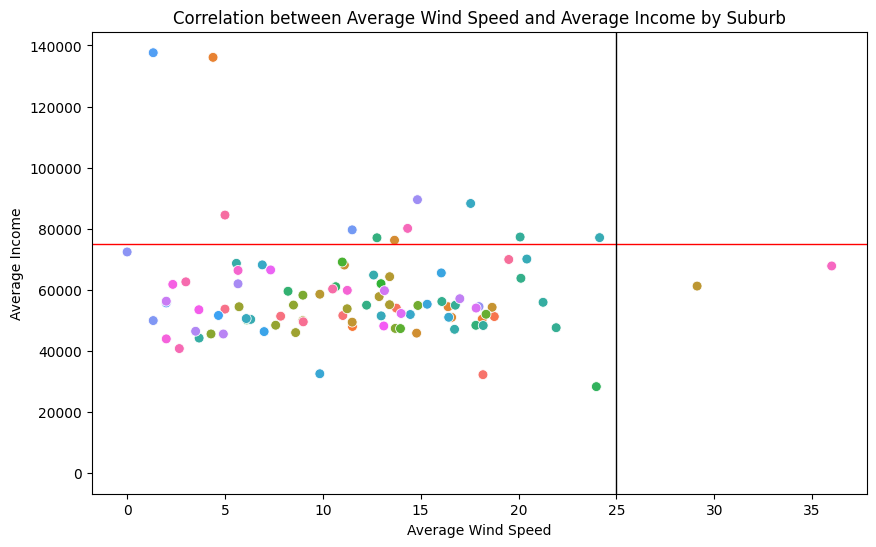

Correlation between Average Wind Speed and Average Income: -0.06912494019920386


In [182]:
# Find Correlation between the average wind speed and amount of traffic accidents of the suburb.
merged_df_suburb_income = pd.merge(weather_df, income_df, on='suburb')
unique_values_income = merged_df_suburb_income['suburb'].unique()

# Find Correlation between the average weather and average income of the suburb.

mean_data_list = []

for suburb in unique_values_income:
    # Filter rows for the current suburb
    suburb_data = merged_df_suburb_income[merged_df_suburb_income['suburb'] == suburb]

    suburb_data['wind_speed_kmh'] = pd.to_numeric(suburb_data['wind_speed_kmh'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and 'income'
    mean_wind_speed_kmh = (suburb_data['wind_speed_kmh']).mean()
    mean_income = suburb_data['mean_aud'].mean()
    
    if mean_income >= 75000:
        print(f"{suburb} average income : {mean_income} with average wind speed : {mean_wind_speed_kmh}")
        
    mean_data_list.append({'suburb': suburb, 'mean_wind_speed_kmh': mean_wind_speed_kmh, 'mean_income': mean_income})


# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# mean_data_df = remove_outliers(mean_data_df, 'mean_wind_speed_kmh')
# mean_data_df = remove_outliers(mean_data_df, 'mean_income')

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_wind_speed_kmh', y='mean_income', hue='suburb', data=mean_data_df, s=50)
plt.title('Correlation between Average Wind Speed and Average Income by Suburb')
plt.xlabel('Average Wind Speed')
plt.ylabel('Average Income')
plt.legend('',frameon=False)
#plt.legend(title='Suburb')
plt.axline((0,75000),(30,75000), linewidth=1, color="r")
plt.axline((25,0), (25,80000), linewidth=1, color="k")
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_wind_speed_kmh'].corr(mean_data_df['mean_income'])

print(f"Correlation between Average Wind Speed and Average Income: {correlation}")

In [183]:
# Merge weather and traffic_2023_df by Month
merged_df_month = pd.merge(weather_df, traffic_2023_df, on='Month', how='inner')
print(merged_df_month)
unique_values = merged_df_month['Month'].unique()
print(unique_values)

                    suburb history_product  latitude  longitude  temperature  \
0               Green Cape        IDN60801     -37.3      150.1         16.1   
1               Green Cape        IDN60801     -37.3      150.1         16.1   
2               Green Cape        IDN60801     -37.3      150.1         16.1   
3               Green Cape        IDN60801     -37.3      150.1         16.1   
4               Green Cape        IDN60801     -37.3      150.1         16.1   
...                    ...             ...       ...        ...          ...   
10183763  Wycheproof (CFA)        IDV60801     -36.1      143.2          7.7   
10183764  Wycheproof (CFA)        IDV60801     -36.1      143.2          7.7   
10183765  Wycheproof (CFA)        IDV60801     -36.1      143.2          7.7   
10183766  Wycheproof (CFA)        IDV60801     -36.1      143.2          7.7   
10183767  Wycheproof (CFA)        IDV60801     -36.1      143.2          7.7   

          apparent_temperature  humidit

In [ ]:
# Find Correlation between the average weather of certain month and amount of traffic accidents of the certain month.

mean_data_list = []

for month in unique_values:
    # Filter rows for the current State
    month_data = merged_df_month[merged_df_month['Month'] == month]

    month_data['rainfall'] = pd.to_numeric(month_data['rainfall'], errors='coerce')
    
    # Calculate mean values for 'rainfall' and count of accidents
    mean_rainfall = month_data['rainfall'].mean()
    count_accident = (month_data['Month'] == month).sum()
    
    mean_data_list.append({'Month': month, 'mean_rainfall': mean_rainfall, 'count_accident': count_accident})

# Convert the list to a DataFrame for plotting
mean_data_df = pd.DataFrame(mean_data_list)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_rainfall', y='count_accident', hue='Month', data=mean_data_df, s=100)
plt.title('Correlation between Average Rainfall and Accident Count by Month')
plt.xlabel('Average Rainfall')
plt.ylabel('Accident Count')
plt.legend(title='Month')
plt.show()

# Drop any rows with NaN values that could have arisen from the mean calculation
mean_data_df.dropna(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = mean_data_df['mean_rainfall'].corr(mean_data_df['count_accident'])

print(f"Correlation between Average Rainfall and Accident Count: {correlation}")




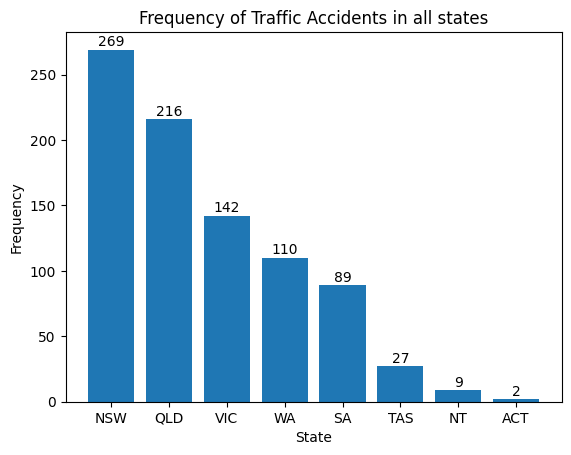

In [117]:
# Capitalised the State
traffic_2023_df['State'] = traffic_2023_df['State'].str.upper()

# Get the frequency count of each state
state_counts = traffic_2023_df['State'].value_counts()

# Create a bar plot of the state counts
bars = plt.bar(state_counts.index, state_counts.values)

# Add the frequency count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Frequency of Traffic Accidents in all states')
plt.xlabel('State')
plt.ylabel('Frequency')

# Show the plot
plt.show()

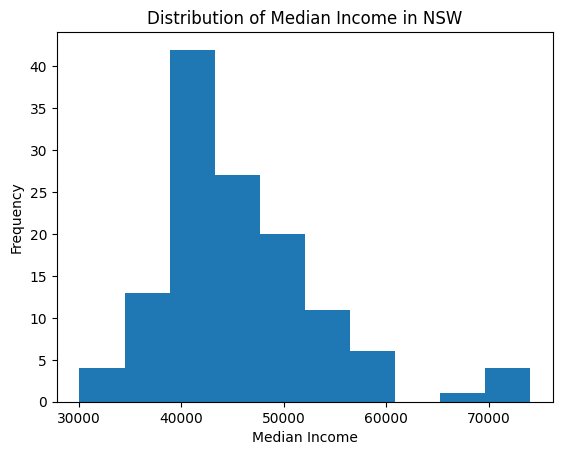

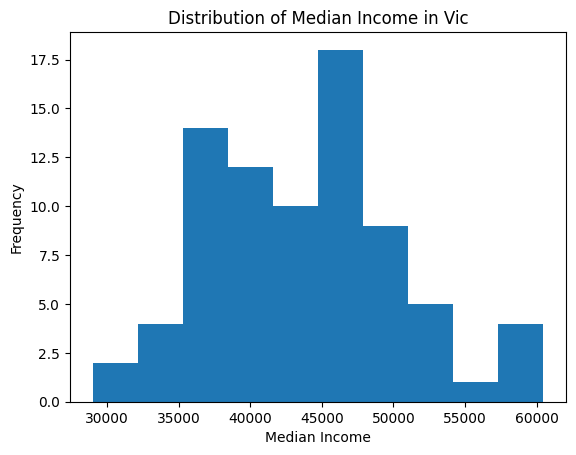

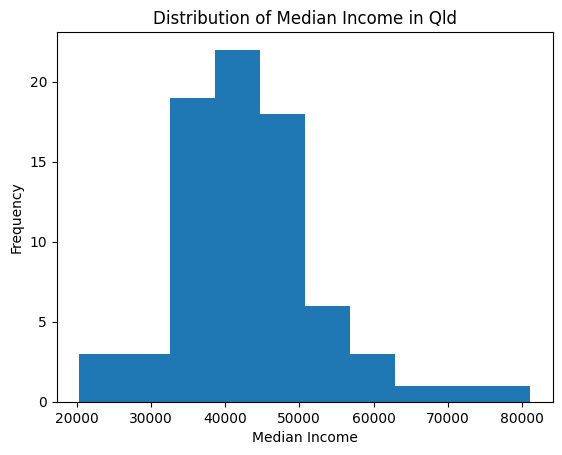

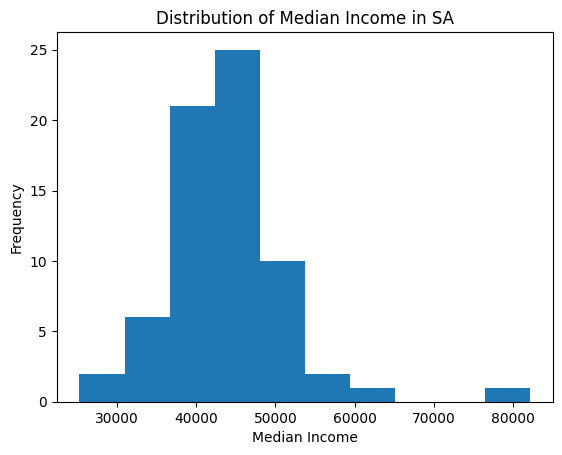

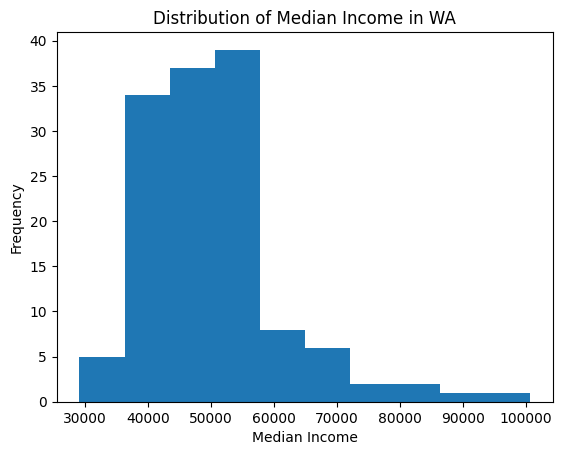

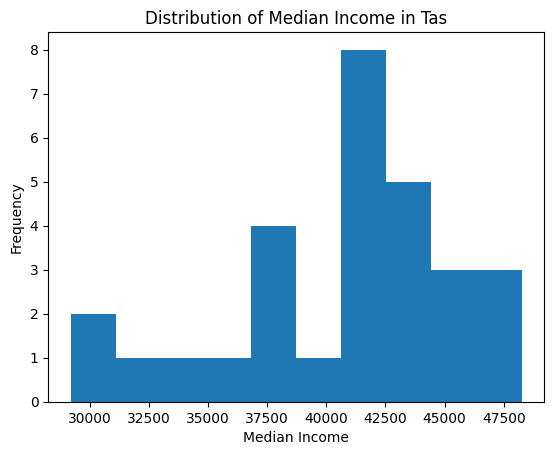

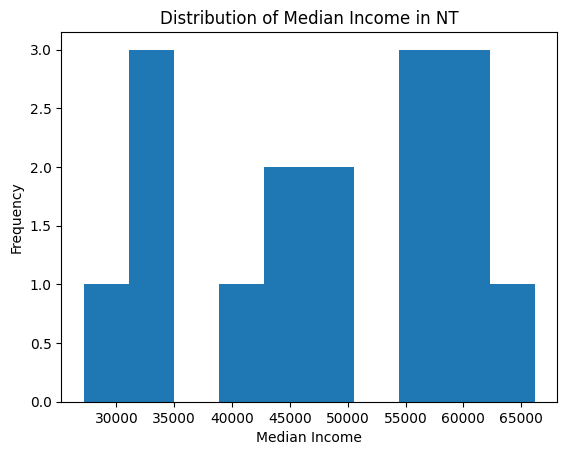

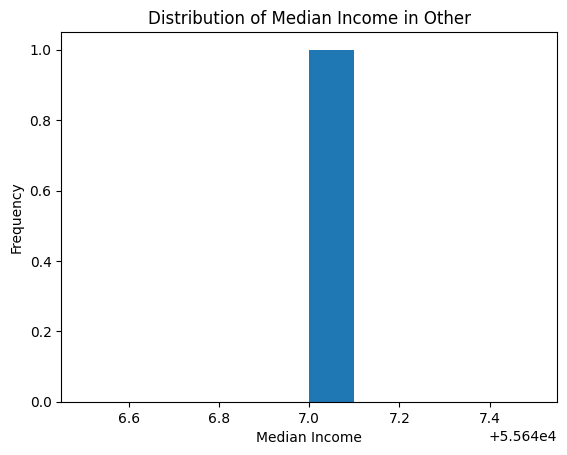

Median income for VIC: nan
Median income for NSW: 44529.0
Median income for QLD: nan
Median income for SA: 44027.0
Median income for WA: 48650.0
Median income for TAS: nan
Median income for NT: 48834.5


In [118]:
# Create a 'State' column based on the 'lga_code'
income_df['State'] = income_df['lga_code'].apply(lambda x: 'NSW' if str(x).startswith('1') 
                                                 else ('Vic' if str(x).startswith('2') 
                                                 else ('Qld' if str(x).startswith('3') 
                                                 else ('SA' if str(x).startswith('4') 
                                                 else ('WA' if str(x).startswith('5') 
                                                 else ('Tas' if str(x).startswith('6') 
                                                 else ('NT' if str(x).startswith('7') 
                                                #  else ('ACT' if str(x).startswith('8') 
                                                 else 'Other')))))))

# for state in ['VIC', 'NSW']:
#     plt.figure()  # Create a new figure
#     state_df = income_df[income_df['State'] == state]
#     state_df['median_aud'].hist(grid=False)
#     plt.title(f'Distribution of Median Income in {state}')
#     plt.xlabel('Median Income')
#     plt.ylabel('Frequency')
# plt.show()

# Loop through each unique state
for state in income_df['State'].unique():
    plt.figure()  # Create a new figure
    state_df = income_df[income_df['State'] == state]
    state_df['median_aud'].hist(grid=False)
    plt.title(f'Distribution of Median Income in {state}')
    plt.xlabel('Median Income')
    plt.ylabel('Frequency')

plt.show()


vic_median = income_df[income_df['State'] == 'VIC']['median_aud'].median()
nsw_median = income_df[income_df['State'] == 'NSW']['median_aud'].median()
qld_median = income_df[income_df['State'] == 'QLD']['median_aud'].median()
sa_median = income_df[income_df['State'] == 'SA']['median_aud'].median()
wa_median = income_df[income_df['State'] == 'WA']['median_aud'].median()
tas_median = income_df[income_df['State'] == 'TAS']['median_aud'].median()
nt_median = income_df[income_df['State'] == 'NT']['median_aud'].median()
# act_median = income_df[income_df['State'] == 'ACT']['median_aud']

# print(income_df[income_df['State'] == 'ACT']['median_aud'])


# Print the medians
print(f"Median income for VIC: {vic_median}")
print(f"Median income for NSW: {nsw_median}")
print(f"Median income for QLD: {qld_median}")
print(f"Median income for SA: {sa_median}")
print(f"Median income for WA: {wa_median}")
print(f"Median income for TAS: {tas_median}")
print(f"Median income for NT: {nt_median}")
# print(f"Median income for ACT: {act_median}")

# Check the data for ACT
# act_data = income_df[income_df['State'] == 'ACT']
# print(act_data['median_aud'].describe())



KeyError: 'State Code'

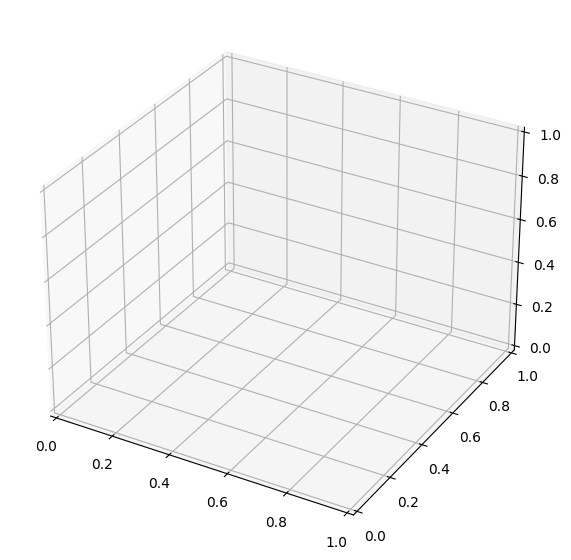

In [119]:
# Calculate the frequency for each state
state_counts = income_df['State'].value_counts()

# Add a column for state counts to the income_df
income_df['Frequency'] = income_df['State'].apply(lambda x: state_counts[x])

# Convert 'State' to categorical codes
income_df['State_Code'] = income_df['State'].astype('category').cat.codes

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
scatter = ax.scatter(income_df['State Code'], income_df['Frequency'], income_df['median_aud'])

ax.set_xlabel('State')
ax.set_ylabel('Number of Records')
ax.set_zlabel('Median Income')

# Set the x-tick labels to the 'State' strings
ax.set_xticks(income_df['State_Code'])
ax.set_xticklabels(income_df['State'])
plt.show()

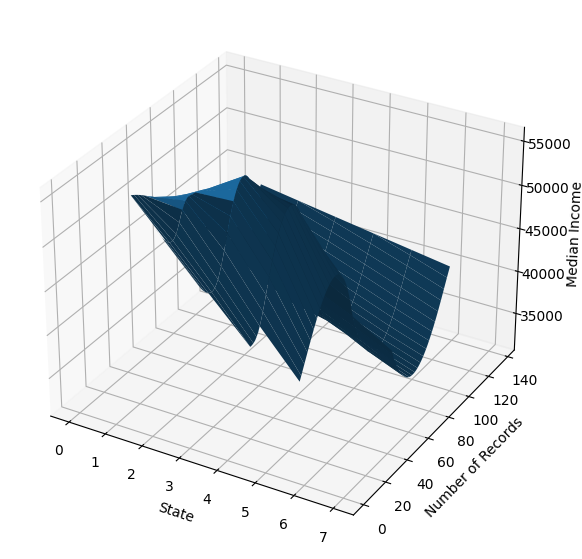

In [120]:
# Create a grid of x and y values
x = np.linspace(income_df['State_Code'].min(), income_df['State_Code'].max(), len(income_df['State'].unique()))
y = np.linspace(income_df['Frequency'].min(), income_df['Frequency'].max(), 100)
x_grid, y_grid = np.meshgrid(x, y)

z_grid = griddata((income_df['State_Code'], income_df['Frequency']), income_df['median_aud'], (x_grid, y_grid), method='cubic')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_grid, y_grid, z_grid)

ax.set_xlabel('State')
ax.set_ylabel('Number of Records')
ax.set_zlabel('Median Income')

# Show the plot
plt.show()

In [121]:
state_fatalities = traffic_2023_df.groupby('State')['Number Fatalities'].sum()

# Create a bar plot
state_fatalities.plot(kind='bar', figsize=(10, 7))

# Set the title and labels
plt.title('Frequency of Fatalities by State')
plt.xlabel('State')
plt.ylabel('Frequency of Fatalities')

# Show the plot
plt.show()

TypeError: no numeric data to plot

-0.003399379714724328


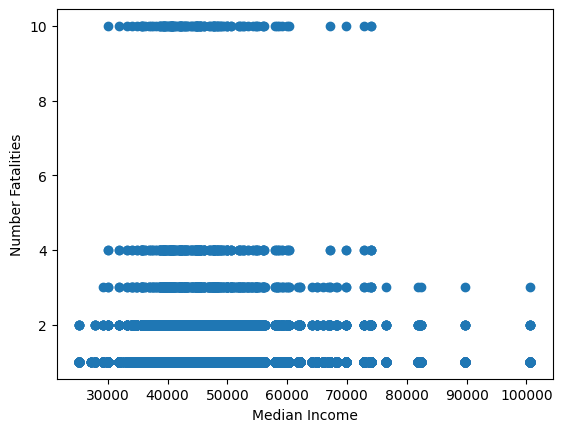

In [123]:
# Convert the 'Number Fatalities' column to numeric
traffic_2023_df['Number Fatalities'] = pd.to_numeric(traffic_2023_df['Number Fatalities'], errors='coerce')
traffic_grouped = traffic_2023_df.groupby('State')['Number Fatalities'].sum()

traffic_state_counts = traffic_2023_df['State'].value_counts()

# Calculate the median of 'median_aud' for each state
income_grouped = income_df.groupby('State')['median_aud'].median()
merged_df = pd.merge(traffic_2023_df, income_df, on='State')

# Calculate the correlation between 'Number Fatalities' and 'median_income'
correlation = merged_df['Number Fatalities'].corr(merged_df['median_aud'])


print(correlation)

plt.scatter(merged_df['median_aud'], merged_df['Number Fatalities'])

# Set the labels
plt.xlabel('Median Income')
plt.ylabel('Number Fatalities')

# Show the plot
plt.show()



In [ ]:
print(income_df.groupby('State')['median_aud'])